# ΕΙΔΙΚΟ ΘΕΜΑ

---
### Θεόκλητος Τσιφτσής 
#### ΑΕΜ: 03247

---
Install & Import Libraries

In [1]:
!pip install tensorflow numpy matplotlib pillow scikit-learn


[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os
import shutil
import random
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Split the dataset into test and train folders

In [ ]:
dataset_root = "../2D_Geometric_Shapes_Dataset/"
train_dir = os.path.join(dataset_root, "train/")
test_dir = os.path.join(dataset_root, "test/")

# gia na mporei na ksanatreksei
if os.path.exists(train_dir):
    shutil.rmtree(train_dir)
if os.path.exists(test_dir):
    shutil.rmtree(test_dir)

for folder in ['triangle', 'circle', 'square']:
    os.makedirs(os.path.join(train_dir, folder), exist_ok=True)
    os.makedirs(os.path.join(test_dir, folder), exist_ok=True)

subset_size = 1000
test_split = 0.1

# 90-10 split to dataset
for shape in ['triangle', 'circle', 'square']:
    shape_path = os.path.join(dataset_root, shape)
    images = os.listdir(shape_path)
    random.shuffle(images)

    images = images[:subset_size]

    test_count = int(len(images) * test_split)

    for img in images[:test_count]:
        shutil.copy(os.path.join(shape_path, img),
                    os.path.join(test_dir, shape, img))

    for img in images[test_count:]:
        shutil.copy(os.path.join(shape_path, img),
                    os.path.join(train_dir, shape, img))

print("train and test split complete. Used 1000 images per shape (900 train / 100 test)")

train and test split complete. Used 1000 images per shape (900 train / 100 test)


### Model Training and Evaluation using a portion of the dataset for testing (10%)

In [ ]:
train_dir = "../2D_Geometric_Shapes_Dataset/train/"
test_dir = "../2D_Geometric_Shapes_Dataset/test/"

image_size = (224, 224)
batch_size = 64

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

class_indices = train_generator.class_indices
label_map = {v: k for k, v in class_indices.items()}
print("Label Map:", label_map)

# 4 convolutional + pooling, flatten, dense, dropout, softmax
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(256, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(len(class_indices), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)

model.save("shape_classifier_model_with_synthetic.h5")
np.save("label_map_with_synthetic.npy", label_map)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

loss, accuracy = model.evaluate(test_generator)
print(f"Final Test Accuracy: {accuracy * 100:.2f}%")

Found 2256 images belonging to 3 classes.
Found 564 images belonging to 3 classes.
Label Map: {0: 'circle', 1: 'square', 2: 'triangle'}
Epoch 1/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 147s 4s/step - accuracy: 0.4388 - loss: 1.3203 - val_accuracy: 0.5071 - val_loss: 0.9482
Epoch 2/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 124s 3s/step - accuracy: 0.6192 - loss: 0.7963 - val_accuracy: 0.7323 - val_loss: 0.5588
Epoch 3/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 122s 3s/step - accuracy: 0.7770 - loss: 0.4984 - val_accuracy: 0.8298 - val_loss: 0.3693
Epoch 4/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 123s 3s/step - accuracy: 0.8737 - loss: 0.3089 - val_accuracy: 0.9149 - val_loss: 0.2067
Epoch 5/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 121s 3s/step - accuracy: 0.9282 - loss: 0.1707 - val_accuracy: 0.9468 - val_loss: 0.1388
Epoch 6/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 124s 3s/step - accuracy: 0.9597 - loss: 0.1149 - val_accuracy: 0.9681 - val_loss: 0.0949
Epoch 7/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 123s 3s/step - accuracy: 0.9805 - loss: 0.0593 - val_accuracy: 0

Found 300 images belonging to 3 classes.
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 828ms/step - accuracy: 0.9800 - loss: 0.0640
Final Test Accuracy: 98.00%


### Final Evaluation and showing misclassifications for model using a portion of the dataset for testing (10%)

Found 300 images belonging to 3 classes.
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 718ms/step - accuracy: 0.9633 - loss: 0.1658
Final Test Accuracy: 96.33%
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 729ms/step

Classification Report:

              precision    recall  f1-score   support

      circle       0.96      0.95      0.95       100
      square       1.00      0.96      0.98       100
    triangle       0.93      0.98      0.96       100

    accuracy                           0.96       300
   macro avg       0.96      0.96      0.96       300
weighted avg       0.96      0.96      0.96       300


Misclassified Samples: 11


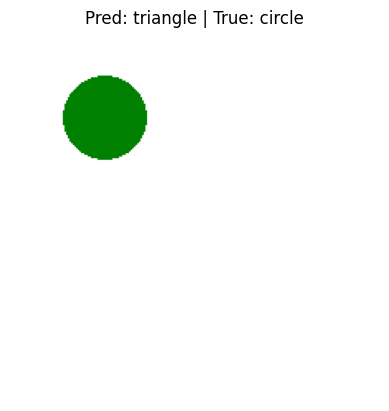

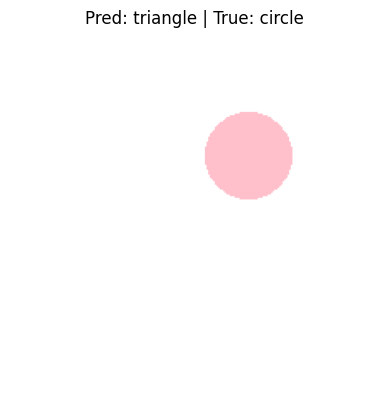

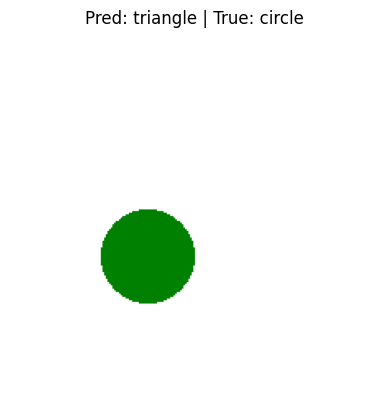

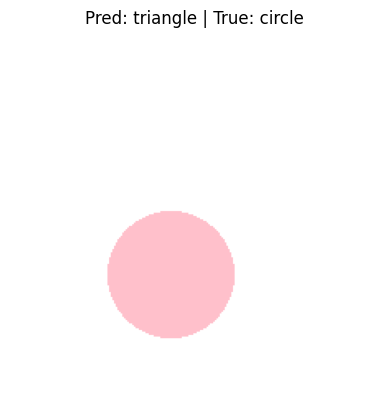

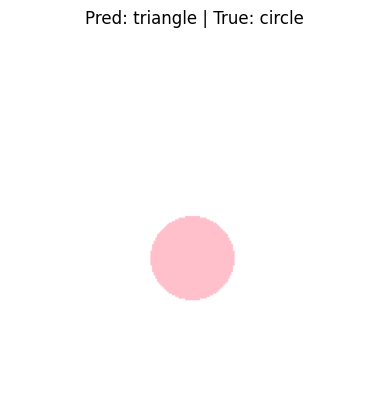

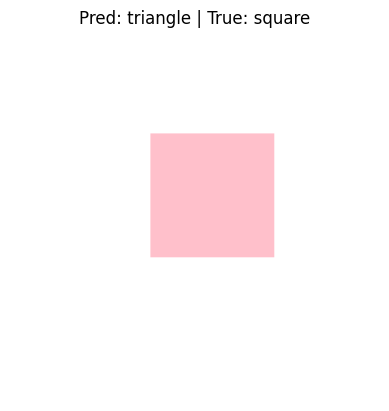

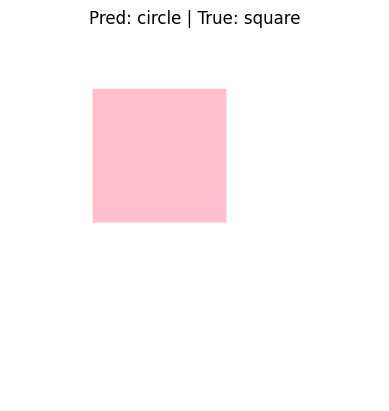

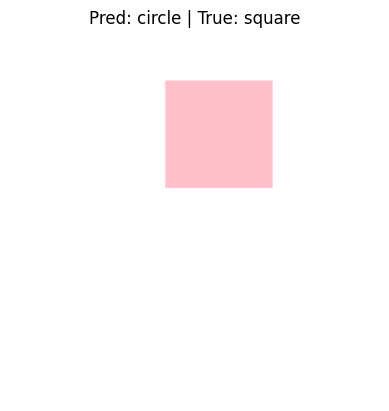

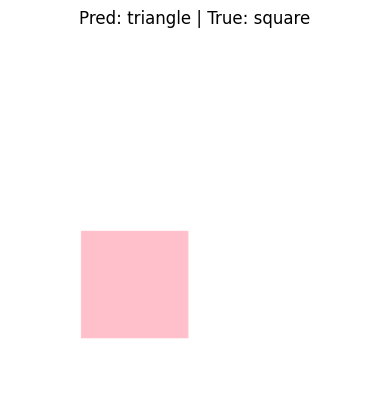

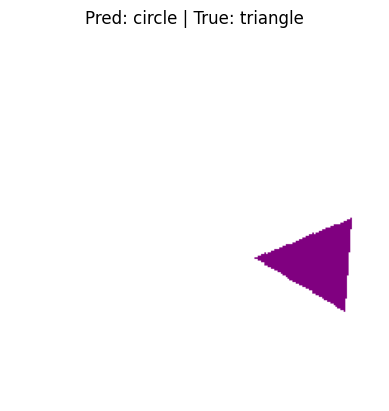

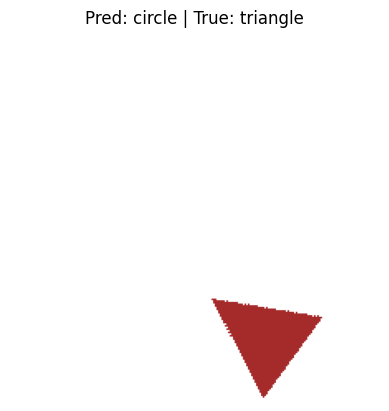

In [7]:
%matplotlib inline  

# teliko accuracy test
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

loss, accuracy = model.evaluate(test_generator)
print(f"Final Test Accuracy: {accuracy * 100:.2f}%")

test_generator.reset()
preds = model.predict(test_generator, verbose=1)

y_pred = np.argmax(preds, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))

misclassified_indices = np.where(y_pred != y_true)[0]
print(f"\nMisclassified Samples: {len(misclassified_indices)}")

#misclassified eikones
for idx in misclassified_indices[:15]:
    img_path = test_generator.filepaths[idx]
    img = Image.open(img_path)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Pred: {class_labels[y_pred[idx]]} | True: {class_labels[y_true[idx]]}")
    plt.show()


### Model Training and Evaluation using Synthetic Data along with the old training Data

In [ ]:
train_dir = "../2D_Geometric_Shapes_Dataset/train_with_synthetic/"
test_dir = "../2D_Geometric_Shapes_Dataset/test/"

image_size = (224, 224)
batch_size = 64

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

class_indices = train_generator.class_indices
label_map = {v: k for k, v in class_indices.items()}
print("Label Map:", label_map)

# 4 convolutional + pooling, flatten, dense, dropout, softmax
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(256, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(len(class_indices), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)

model.save("shape_classifier_model_with_synthetic.h5")
np.save("label_map_with_synthetic.npy", label_map)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

loss, accuracy = model.evaluate(test_generator)
print(f"Final Test Accuracy: {accuracy * 100:.2f}%")

Found 2256 images belonging to 3 classes.
Found 564 images belonging to 3 classes.


c:\Users\teots\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3938 - loss: 1.1239

c:\Users\teots\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


34/34 ━━━━━━━━━━━━━━━━━━━━ 136s 4s/step - accuracy: 0.4685 - loss: 1.0138 - val_accuracy: 0.6648 - val_loss: 0.6978
Epoch 2/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 119s 4s/step - accuracy: 0.7102 - loss: 0.6001 - val_accuracy: 0.7870 - val_loss: 0.3945
Epoch 3/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 119s 4s/step - accuracy: 0.8565 - loss: 0.3083 - val_accuracy: 0.9000 - val_loss: 0.2199
Epoch 4/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 115s 3s/step - accuracy: 0.9477 - loss: 0.1469 - val_accuracy: 0.9556 - val_loss: 0.1222
Epoch 5/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 116s 3s/step - accuracy: 0.9755 - loss: 0.0845 - val_accuracy: 0.9537 - val_loss: 0.1346
Epoch 6/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 118s 3s/step - accuracy: 0.9796 - loss: 0.0645 - val_accuracy: 0.9722 - val_loss: 0.0851
Epoch 7/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 117s 3s/step - accuracy: 0.9921 - loss: 0.0286 - val_accuracy: 0.9796 - val_loss: 0.0759
Epoch 8/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 117s 3s/step - accuracy: 0.9981 - loss: 0.0136 - val_accuracy: 0.9759 - val_loss: 0.

Found 300 images belonging to 3 classes.
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 724ms/step - accuracy: 0.3667 - loss: 1.1022
Final Test Accuracy: 36.67%


Found 300 images belonging to 3 classes.
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 827ms/step - accuracy: 0.9800 - loss: 0.0640
Final Test Accuracy: 98.00%
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 800ms/step

Classification Report:

              precision    recall  f1-score   support

      circle       0.96      0.98      0.97       100
      square       1.00      1.00      1.00       100
    triangle       0.98      0.96      0.97       100

    accuracy                           0.98       300
   macro avg       0.98      0.98      0.98       300
weighted avg       0.98      0.98      0.98       300


Misclassified Samples: 6


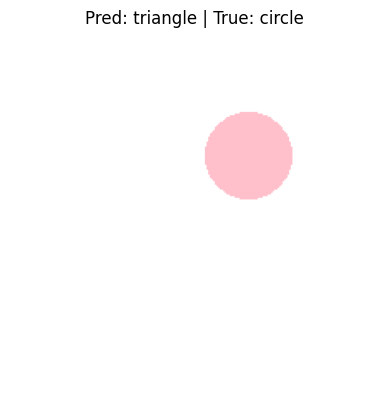

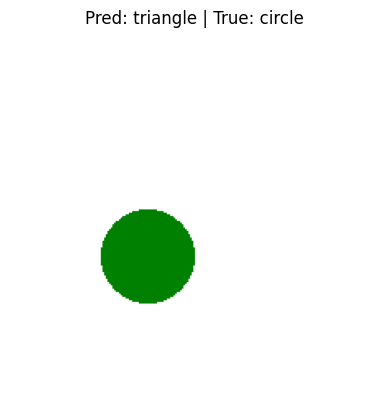

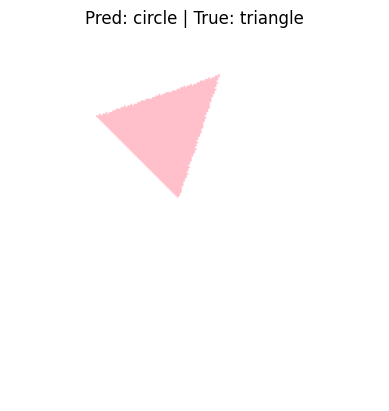

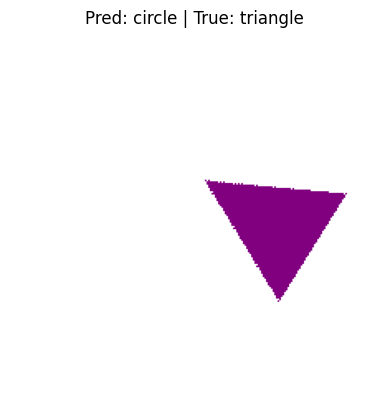

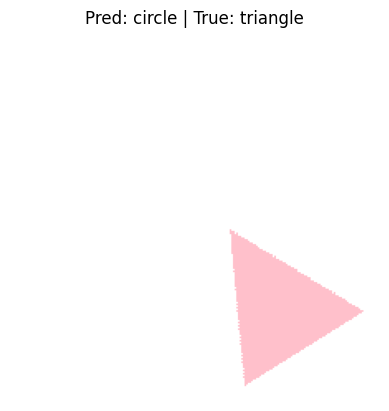

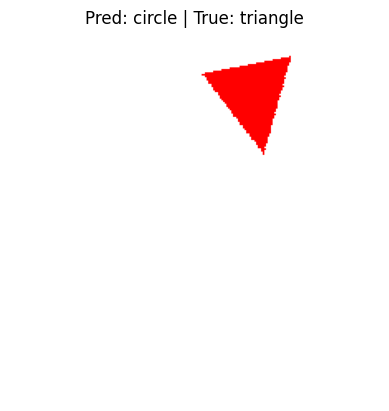

In [12]:
%matplotlib inline  

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

loss, accuracy = model.evaluate(test_generator)
print(f"Final Test Accuracy: {accuracy * 100:.2f}%")

test_generator.reset()
preds = model.predict(test_generator, verbose=1)

y_pred = np.argmax(preds, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))

misclassified_indices = np.where(y_pred != y_true)[0]
print(f"\nMisclassified Samples: {len(misclassified_indices)}")

for idx in misclassified_indices[:15]:
    img_path = test_generator.filepaths[idx]
    img = Image.open(img_path)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Pred: {class_labels[y_pred[idx]]} | True: {class_labels[y_true[idx]]}")
    plt.show()